# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



----

## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
from src.models import MLP, ResidualMLP, SimpleCNN, CNN, get_resnet18
from src.trainer import Trainer, EarlyStopping, plot_history, test_model

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [3]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = int(0.2*len(ds_train))
train_size = len(ds_train) - val_size

generator = torch.Generator().manual_seed(42)  # fix seed for reproducibility
ds_train, ds_val = torch.utils.data.random_split(ds_train, [train_size, val_size], generator=generator)

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
INPUT_CHANNELS = 1   
INPUT_SIZE_FLAT = 28 * 28 # 784, per i modelli MLP
NUM_CLASSES = 10 


train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dati pronti:")
print(f"- {len(ds_train)} campioni di training in {len(train_loader)} batch")
print(f"- {len(ds_val)} campioni di validazione in {len(val_loader)} batch")
print(f"- {len(ds_test)} campioni di test in {len(test_loader)} batch")

Dati pronti:
- 48000 campioni di training in 375 batch
- 12000 campioni di validazione in 94 batch
- 10000 campioni di test in 79 batch


### SMALL (light) MLP

In [ ]:


if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")


# --- CNN ---
# NOTA: MNIST ha 1 solo canale, quindi dobbiamo specificare in_channels=1
#model = SimpleCNN(in_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES)

# --- ResNet-18 ---
# Dobbiamo modificare il primo layer per accettare 1 canale invece di 3
# model = get_resnet18(num_classes=NUM_CLASSES, use_pretrained=False)
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# --- MLP ---
model_small = MLP(input_size=INPUT_SIZE_FLAT, hidden_size=3, output_size=NUM_CLASSES)

Using device: mps


In [ ]:
# --- MLP ---
model_small = MLP(input_size=INPUT_SIZE_FLAT, hidden_size=3, output_size=NUM_CLASSES)

LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_small.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    mode='min'
)

trainer = Trainer(
    model=model_small,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1",
        "name": "small MLP",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_small = trainer.fit(NUM_EPOCHS)

EarlyStopping enabled. Monitoring 'val_loss' with patience=3.


wandb: Currently logged in as: ciacciaaaa (ciacciaaaa-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 30 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/30 | Train Loss: 1.4837 | Val Loss: 1.0758 | Val Acc: 0.6555


Epoch 2/30 | Train Loss: 0.9556 | Val Loss: 0.9165 | Val Acc: 0.7155


Epoch 3/30 | Train Loss: 0.8731 | Val Loss: 0.8784 | Val Acc: 0.7241


Epoch 4/30 | Train Loss: 0.8393 | Val Loss: 0.8476 | Val Acc: 0.7428


Epoch 5/30 | Train Loss: 0.8154 | Val Loss: 0.8322 | Val Acc: 0.7490


Epoch 6/30 | Train Loss: 0.7981 | Val Loss: 0.8164 | Val Acc: 0.7527


Epoch 7/30 | Train Loss: 0.7861 | Val Loss: 0.8074 | Val Acc: 0.7530


Epoch 8/30 | Train Loss: 0.7743 | Val Loss: 0.7968 | Val Acc: 0.7657


Epoch 9/30 | Train Loss: 0.7646 | Val Loss: 0.7905 | Val Acc: 0.7639


Epoch 10/30 | Train Loss: 0.7575 | Val Loss: 0.7793 | Val Acc: 0.7682


Epoch 11/30 | Train Loss: 0.7507 | Val Loss: 0.7728 | Val Acc: 0.7709


Epoch 12/30 | Train Loss: 0.7456 | Val Loss: 0.7729 | Val Acc: 0.7708


Epoch 13/30 | Train Loss: 0.7405 | Val Loss: 0.7617 | Val Acc: 0.7770


Epoch 14/30 | Train Loss: 0.7358 | Val Loss: 0.7586 | Val Acc: 0.7790


Epoch 15/30 | Train Loss: 0.7321 | Val Loss: 0.7578 | Val Acc: 0.7769


Epoch 16/30 | Train Loss: 0.7297 | Val Loss: 0.7550 | Val Acc: 0.7790


Epoch 17/30 | Train Loss: 0.7270 | Val Loss: 0.7503 | Val Acc: 0.7826


Epoch 18/30 | Train Loss: 0.7232 | Val Loss: 0.7498 | Val Acc: 0.7837


Epoch 19/30 | Train Loss: 0.7211 | Val Loss: 0.7463 | Val Acc: 0.7847


Epoch 20/30 | Train Loss: 0.7191 | Val Loss: 0.7472 | Val Acc: 0.7807


Epoch 21/30 | Train Loss: 0.7175 | Val Loss: 0.7441 | Val Acc: 0.7855


Epoch 22/30 | Train Loss: 0.7168 | Val Loss: 0.7519 | Val Acc: 0.7779


Epoch 23/30 | Train Loss: 0.7133 | Val Loss: 0.7457 | Val Acc: 0.7838


Epoch 24/30 | Train Loss: 0.7120 | Val Loss: 0.7412 | Val Acc: 0.7862


Epoch 25/30 | Train Loss: 0.7098 | Val Loss: 0.7389 | Val Acc: 0.7885


Epoch 26/30 | Train Loss: 0.7087 | Val Loss: 0.7431 | Val Acc: 0.7864


Epoch 27/30 | Train Loss: 0.7076 | Val Loss: 0.7351 | Val Acc: 0.7891


Epoch 28/30 | Train Loss: 0.7047 | Val Loss: 0.7377 | Val Acc: 0.7878


Epoch 29/30 | Train Loss: 0.7060 | Val Loss: 0.7385 | Val Acc: 0.7851


Epoch 30/30 | Train Loss: 0.7038 | Val Loss: 0.7328 | Val Acc: 0.7881


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████▇████████
val/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train/loss,0.70379
val/accuracy,0.78808
val/loss,0.73282



--- Training Complete ---


AttributeError: 'NoneType' object has no attribute '_log'

In [7]:
test_results = trainer.test(test_loader)
print(test_results)

Testing:   0%|          | 0/79 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                        


--- Test Results ---
Loss: 0.7237 | Accuracy: 0.7933
{'test_loss': 0.7236881071253668, 'test_accuracy': 0.7932999730110168}


In [8]:
# --- MLP ---
model_medium = MLP(input_size=INPUT_SIZE_FLAT, hidden_size=10, output_size=NUM_CLASSES)

LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_medium.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    mode='min'
)

trainer = Trainer(
    model=model_medium,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1",
        "name": "medium MLP",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_small = trainer.fit(NUM_EPOCHS)

EarlyStopping enabled. Monitoring 'val_loss' with patience=3.


Starting training for 30 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/30 | Train Loss: 0.6479 | Val Loss: 0.3490 | Val Acc: 0.9010


Epoch 2/30 | Train Loss: 0.3053 | Val Loss: 0.3135 | Val Acc: 0.9101


Epoch 3/30 | Train Loss: 0.2766 | Val Loss: 0.2998 | Val Acc: 0.9140


Epoch 4/30 | Train Loss: 0.2613 | Val Loss: 0.2920 | Val Acc: 0.9179


Epoch 5/30 | Train Loss: 0.2519 | Val Loss: 0.2808 | Val Acc: 0.9212


Epoch 6/30 | Train Loss: 0.2430 | Val Loss: 0.2787 | Val Acc: 0.9208


Epoch 7/30 | Train Loss: 0.2370 | Val Loss: 0.2823 | Val Acc: 0.9186


Epoch 8/30 | Train Loss: 0.2320 | Val Loss: 0.2753 | Val Acc: 0.9213


Epoch 9/30 | Train Loss: 0.2273 | Val Loss: 0.2694 | Val Acc: 0.9242


Epoch 10/30 | Train Loss: 0.2225 | Val Loss: 0.2664 | Val Acc: 0.9255


Epoch 11/30 | Train Loss: 0.2183 | Val Loss: 0.2611 | Val Acc: 0.9259


Epoch 12/30 | Train Loss: 0.2149 | Val Loss: 0.2671 | Val Acc: 0.9249


Epoch 13/30 | Train Loss: 0.2122 | Val Loss: 0.2622 | Val Acc: 0.9264


Epoch 14/30 | Train Loss: 0.2110 | Val Loss: 0.2638 | Val Acc: 0.9260

EarlyStopping triggered after 3 epochs with no improvement.
Training stopped early at epoch 14.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁
val/accuracy,▁▄▅▆▇▆▆▇▇█████
val/loss,█▅▄▃▃▂▃▂▂▁▁▁▁▁
epoch,14
train/loss,0.21103
val/accuracy,0.926
val/loss,0.2638



--- Training Complete ---


In [11]:
test_results = trainer.test(test_loader)
print(test_results)


--- Test Results ---
Loss: 0.2394 | Accuracy: 0.9322
{'test_loss': 0.23936853861978538, 'test_accuracy': 0.932200014591217}


In [12]:
# --- MLP ---
model_big = MLP(input_size=INPUT_SIZE_FLAT, hidden_size=64, output_size=NUM_CLASSES)

LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_big.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    mode='min'
)

trainer = Trainer(
    model=model_big,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1",
        "name": "big MLP",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_big = trainer.fit(NUM_EPOCHS)

EarlyStopping enabled. Monitoring 'val_loss' with patience=3.


Starting training for 30 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/30 | Train Loss: 0.3718 | Val Loss: 0.2423 | Val Acc: 0.9305


Epoch 2/30 | Train Loss: 0.1853 | Val Loss: 0.1828 | Val Acc: 0.9464


Epoch 3/30 | Train Loss: 0.1354 | Val Loss: 0.1467 | Val Acc: 0.9572


Epoch 4/30 | Train Loss: 0.1075 | Val Loss: 0.1290 | Val Acc: 0.9612


Epoch 5/30 | Train Loss: 0.0882 | Val Loss: 0.1170 | Val Acc: 0.9651


Epoch 6/30 | Train Loss: 0.0758 | Val Loss: 0.1148 | Val Acc: 0.9657


Epoch 7/30 | Train Loss: 0.0636 | Val Loss: 0.1053 | Val Acc: 0.9682


Epoch 8/30 | Train Loss: 0.0557 | Val Loss: 0.1071 | Val Acc: 0.9683


Epoch 9/30 | Train Loss: 0.0487 | Val Loss: 0.1089 | Val Acc: 0.9678


Epoch 10/30 | Train Loss: 0.0427 | Val Loss: 0.1004 | Val Acc: 0.9703


Epoch 11/30 | Train Loss: 0.0373 | Val Loss: 0.1090 | Val Acc: 0.9676


Epoch 12/30 | Train Loss: 0.0337 | Val Loss: 0.1045 | Val Acc: 0.9702


Epoch 13/30 | Train Loss: 0.0291 | Val Loss: 0.1004 | Val Acc: 0.9722

EarlyStopping triggered after 3 epochs with no improvement.
Training stopped early at epoch 13.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/loss,█▄▃▃▂▂▂▂▁▁▁▁▁
val/accuracy,▁▄▅▆▇▇▇▇▇█▇██
val/loss,█▅▃▂▂▂▁▁▁▁▁▁▁
epoch,13
train/loss,0.02912
val/accuracy,0.97217
val/loss,0.1004



--- Training Complete ---


In [ ]:
test_results = trainer.test(test_loader)


--- Test Results ---
Loss: 0.0876 | Accuracy: 0.9753


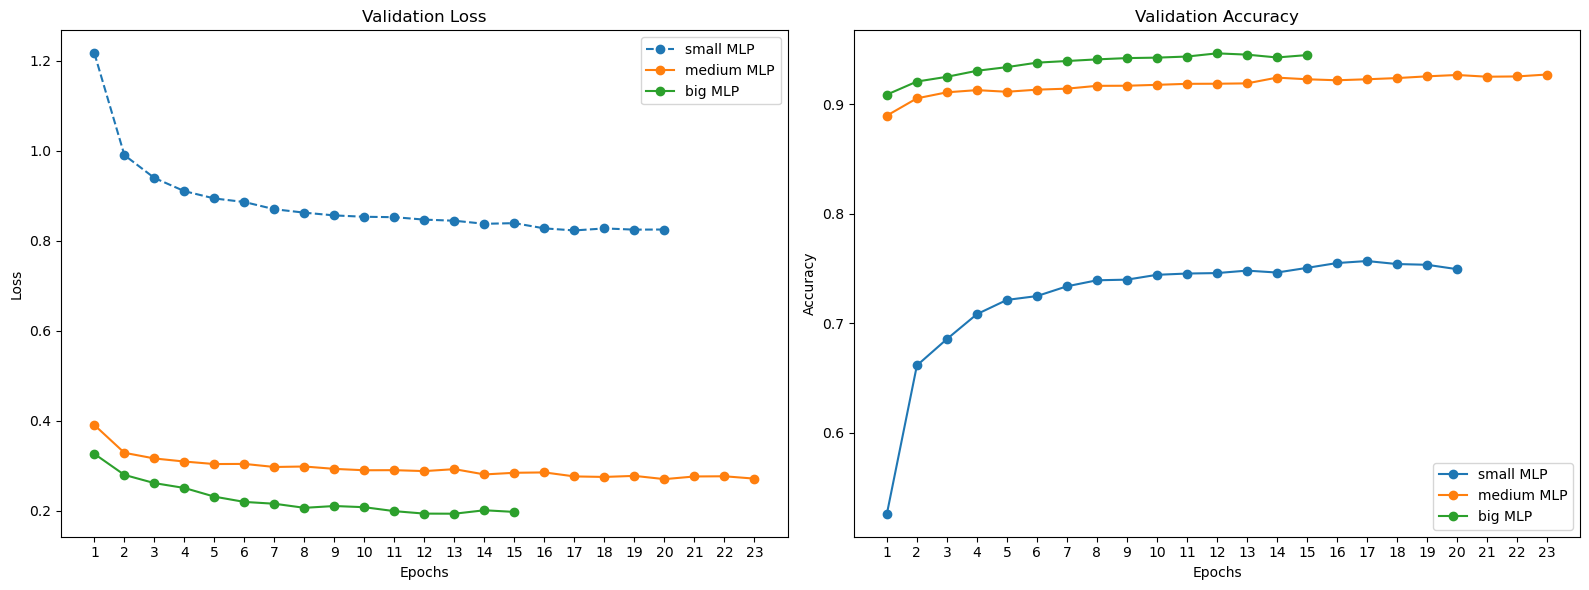

In [22]:
epochs_s = range(1, len(history_small['loss']) + 1)
epochs_m = range(1, len(history_medium['loss']) + 1)
epochs_b = range(1, len(history_big['loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training and Validation Loss
ax1.plot(epochs_s, history_small['val_loss'], 'o--', label='small MLP')
ax1.plot(epochs_m, history_medium['val_loss'], 'o-', label='medium MLP')
ax1.plot(epochs_b, history_big['val_loss'], 'o-', label='big MLP')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_xticks(epochs_m)

# Validation Accuracy
ax2.plot(epochs_s, history_small['val_accuracy'], 'o-', label='small MLP')
ax2.plot(epochs_m, history_medium['val_accuracy'], 'o-', label='medium MLP')
ax2.plot(epochs_b, history_big['val_accuracy'], 'o-', label='big MLP')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_xticks(epochs_m)

plt.tight_layout()
plt.show()

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [28]:
# --- ResidualMLP ---
ResMLP = ResidualMLP(input_size=INPUT_SIZE_FLAT, hidden_size=64, output_size=NUM_CLASSES, num_blocks=3)

LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResMLP.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    mode='min'
)

trainer = Trainer(
    model=ResMLP,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1",
        "name": "Residual MLP",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_small = trainer.fit(NUM_EPOCHS)

EarlyStopping enabled. Monitoring 'val_loss' with patience=3.


Starting training for 30 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/30 | Train Loss: 0.3268 | Val Loss: 0.1906 | Val Acc: 0.9421


Epoch 2/30 | Train Loss: 0.1421 | Val Loss: 0.1256 | Val Acc: 0.9623


Epoch 3/30 | Train Loss: 0.0989 | Val Loss: 0.1187 | Val Acc: 0.9630


Epoch 4/30 | Train Loss: 0.0789 | Val Loss: 0.1115 | Val Acc: 0.9664


Epoch 5/30 | Train Loss: 0.0660 | Val Loss: 0.1070 | Val Acc: 0.9668


Epoch 6/30 | Train Loss: 0.0541 | Val Loss: 0.1007 | Val Acc: 0.9711


Epoch 7/30 | Train Loss: 0.0484 | Val Loss: 0.1043 | Val Acc: 0.9707


Epoch 8/30 | Train Loss: 0.0419 | Val Loss: 0.1063 | Val Acc: 0.9686


Epoch 9/30 | Train Loss: 0.0350 | Val Loss: 0.1101 | Val Acc: 0.9696

EarlyStopping triggered after 3 epochs with no improvement.
Training stopped early at epoch 9.


epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
train/loss,█▄▃▂▂▁▁▁▁
val/accuracy,▁▆▆▇▇██▇█
val/loss,█▃▂▂▁▁▁▁▂
epoch,9
train/loss,0.03498
val/accuracy,0.96958
val/loss,0.11007



--- Training Complete ---


In [30]:
test_results = trainer.test(test_loader)


--- Test Results ---
Loss: 0.1053 | Accuracy: 0.9707


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# --- TRAIN TRANSFORMS con data augmentation ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),          # flip orizzontale
    transforms.RandomCrop(32, padding=4),      # crop casuale con padding
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.247, 0.243, 0.261))
])

# --- VALIDATION / TEST TRANSFORMS senza augmentation ---
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.247, 0.243, 0.261))
])

# --- Dataset ---
ds_train_full = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=val_transform)

# Split train in train / val (80/20)
val_size = int(0.2 * len(ds_train_full))
train_size = len(ds_train_full) - val_size

generator = torch.Generator().manual_seed(42)
ds_train, ds_val = torch.utils.data.random_split(ds_train_full, [train_size, val_size], generator=generator)

# Modifica il transform del validation set per rimuovere augmentation
ds_val.dataset.transform = val_transform


In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
INPUT_CHANNELS = 1   
#INPUT_SIZE_FLAT = 28 * 28 # 784, per i modelli MLP
NUM_CLASSES = 10 


train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dati pronti:")
print(f"- {len(ds_train)} campioni di training in {len(train_loader)} batch")
print(f"- {len(ds_val)} campioni di validazione in {len(val_loader)} batch")
print(f"- {len(ds_test)} campioni di test in {len(test_loader)} batch")

Dati pronti:
- 40000 campioni di training in 313 batch
- 10000 campioni di validazione in 79 batch
- 10000 campioni di test in 79 batch


In [5]:
from src.models import SimpleCNN, CNN, ResNet18

In [12]:
# --- SimpleCNN ---
simpleCNN = SimpleCNN(in_channels=3, num_classes=10)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simpleCNN.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    mode='min'
)

trainer = Trainer(
    model=simpleCNN,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1-cifar",
        "name": "SimpleCNN",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_simplecnn = trainer.fit(NUM_EPOCHS)

Using device: mps
EarlyStopping enabled. Monitoring 'val_loss' with patience=5.


Starting training for 50 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.4743 | Val Loss: 1.2809 | Val Acc: 0.5454


Epoch 2/50 | Train Loss: 1.1427 | Val Loss: 1.1124 | Val Acc: 0.6034


Epoch 3/50 | Train Loss: 1.0028 | Val Loss: 1.0452 | Val Acc: 0.6274


Epoch 4/50 | Train Loss: 0.9069 | Val Loss: 0.9822 | Val Acc: 0.6576


Epoch 5/50 | Train Loss: 0.8211 | Val Loss: 0.9183 | Val Acc: 0.6787


Epoch 6/50 | Train Loss: 0.7470 | Val Loss: 0.9315 | Val Acc: 0.6702


Epoch 7/50 | Train Loss: 0.6777 | Val Loss: 0.9353 | Val Acc: 0.6783


Epoch 8/50 | Train Loss: 0.6134 | Val Loss: 0.9194 | Val Acc: 0.6846


Epoch 9/50 | Train Loss: 0.5442 | Val Loss: 0.9291 | Val Acc: 0.6872


Epoch 10/50 | Train Loss: 0.4773 | Val Loss: 0.9797 | Val Acc: 0.6866

EarlyStopping triggered after 5 epochs with no improvement.
Training stopped early at epoch 10.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train/loss,█▆▅▄▃▃▂▂▁▁
val/accuracy,▁▄▅▇█▇████
val/loss,█▅▃▂▁▁▁▁▁▂
epoch,10
train/loss,0.4773
val/accuracy,0.6866
val/loss,0.97967



--- Training Complete ---


In [6]:
# --- CNN ---
cnn = CNN(in_channels=3, num_classes=10)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode='min'
)

trainer = Trainer(
    model=cnn,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1-cifar",
        "name": "CNN",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_cnn = trainer.fit(NUM_EPOCHS)
trainer.save_model("/Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models")

Using device: mps
EarlyStopping enabled. Monitoring 'val_loss' with patience=10.


wandb: Currently logged in as: ciacciaaaa (ciacciaaaa-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 50 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.6053 | Val Loss: 1.2101 | Val Acc: 0.5515


Epoch 2/50 | Train Loss: 1.1266 | Val Loss: 1.0939 | Val Acc: 0.6085


Epoch 3/50 | Train Loss: 0.9183 | Val Loss: 0.9606 | Val Acc: 0.6624


Epoch 4/50 | Train Loss: 0.7781 | Val Loss: 0.7865 | Val Acc: 0.7246


Epoch 5/50 | Train Loss: 0.6869 | Val Loss: 0.7134 | Val Acc: 0.7529


Epoch 6/50 | Train Loss: 0.6080 | Val Loss: 0.6034 | Val Acc: 0.7873


Epoch 7/50 | Train Loss: 0.5302 | Val Loss: 0.5941 | Val Acc: 0.8005


Epoch 8/50 | Train Loss: 0.4634 | Val Loss: 0.5596 | Val Acc: 0.8049


Epoch 9/50 | Train Loss: 0.4136 | Val Loss: 0.5656 | Val Acc: 0.8133


Epoch 10/50 | Train Loss: 0.3542 | Val Loss: 0.7192 | Val Acc: 0.7931


Epoch 11/50 | Train Loss: 0.3052 | Val Loss: 0.6182 | Val Acc: 0.8174


Epoch 12/50 | Train Loss: 0.2704 | Val Loss: 0.5592 | Val Acc: 0.8338


Epoch 13/50 | Train Loss: 0.2263 | Val Loss: 0.5956 | Val Acc: 0.8306


Epoch 14/50 | Train Loss: 0.2059 | Val Loss: 0.6334 | Val Acc: 0.8233


Epoch 15/50 | Train Loss: 0.1763 | Val Loss: 0.5911 | Val Acc: 0.8443


Epoch 16/50 | Train Loss: 0.1548 | Val Loss: 0.6743 | Val Acc: 0.8371


Epoch 17/50 | Train Loss: 0.1304 | Val Loss: 0.6935 | Val Acc: 0.8307


Epoch 18/50 | Train Loss: 0.1109 | Val Loss: 0.6767 | Val Acc: 0.8388

EarlyStopping triggered after 10 epochs with no improvement.
Training stopped early at epoch 18.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val/accuracy,▁▂▄▅▆▇▇▇▇▇▇██▇████
val/loss,█▇▅▃▃▁▁▁▁▃▂▁▁▂▁▂▂▂
epoch,18
train/loss,0.11088
val/accuracy,0.8388
val/loss,0.67666



--- Training Complete ---
Model saved to /Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models/CNN_final_20250821-181751.pth


'/Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models/CNN_final_20250821-181751.pth'

In [7]:
from src.models import ResNet18, ResNet34, ResNet50

# --- Resnet18 ---
resnet18 = ResNet18()

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(resnet.parameters(), lr=LEARNING_RATE)

optimizer = optim.SGD(
    resnet18.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode='min'
)

trainer = Trainer(
    model=resnet18,
    train_dl=train_loader,
    val_dl=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=True,
    wandb_config={
        "project": "DLA-Lab1-cifar",
        "name": "Resnet18",
        "config": {
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE
        }
    }
)

history_resnet = trainer.fit(NUM_EPOCHS)

Using device: mps
EarlyStopping enabled. Monitoring 'val_loss' with patience=10.


wandb: Currently logged in as: ciacciaaaa (ciacciaaaa-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 50 epochs on device 'mps'...


Training Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.9377 | Val Loss: 1.5552 | Val Acc: 0.4316


Epoch 2/50 | Train Loss: 1.4305 | Val Loss: 1.3109 | Val Acc: 0.5229


Epoch 3/50 | Train Loss: 1.2015 | Val Loss: 1.1709 | Val Acc: 0.5796


Epoch 4/50 | Train Loss: 1.0169 | Val Loss: 1.0448 | Val Acc: 0.6275


Epoch 5/50 | Train Loss: 0.8571 | Val Loss: 0.9369 | Val Acc: 0.6623


Epoch 6/50 | Train Loss: 0.7443 | Val Loss: 0.7949 | Val Acc: 0.7198


Epoch 7/50 | Train Loss: 0.6488 | Val Loss: 1.0398 | Val Acc: 0.6523


Epoch 8/50 | Train Loss: 0.5683 | Val Loss: 0.8461 | Val Acc: 0.7137


Epoch 9/50 | Train Loss: 0.4809 | Val Loss: 0.7979 | Val Acc: 0.7282


Epoch 10/50 | Train Loss: 0.4278 | Val Loss: 0.7811 | Val Acc: 0.7333


Epoch 11/50 | Train Loss: 0.3689 | Val Loss: 0.8485 | Val Acc: 0.7326


Epoch 12/50 | Train Loss: 0.3246 | Val Loss: 0.7794 | Val Acc: 0.7572


Epoch 13/50 | Train Loss: 0.2871 | Val Loss: 0.7889 | Val Acc: 0.7544


Epoch 14/50 | Train Loss: 0.2605 | Val Loss: 0.6887 | Val Acc: 0.7844


Epoch 15/50 | Train Loss: 0.2463 | Val Loss: 0.9369 | Val Acc: 0.7221


Epoch 16/50 | Train Loss: 0.2318 | Val Loss: 0.9598 | Val Acc: 0.7155


Epoch 17/50 | Train Loss: 0.2101 | Val Loss: 0.8276 | Val Acc: 0.7543


Epoch 18/50 | Train Loss: 0.2100 | Val Loss: 0.8671 | Val Acc: 0.7509


Epoch 19/50 | Train Loss: 0.1901 | Val Loss: 0.8004 | Val Acc: 0.7641


Epoch 20/50 | Train Loss: 0.1945 | Val Loss: 0.7240 | Val Acc: 0.7788


Epoch 21/50 | Train Loss: 0.1828 | Val Loss: 0.9320 | Val Acc: 0.7224


Epoch 22/50 | Train Loss: 0.1826 | Val Loss: 0.7778 | Val Acc: 0.7646


Epoch 23/50 | Train Loss: 0.1861 | Val Loss: 0.8760 | Val Acc: 0.7527


Epoch 24/50 | Train Loss: 0.1702 | Val Loss: 0.8715 | Val Acc: 0.7565

EarlyStopping triggered after 10 epochs with no improvement.
Training stopped early at epoch 24.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▅▆▇▅▇▇▇▇▇▇█▇▇▇▇██▇█▇▇
val/loss,█▆▅▄▃▂▄▂▂▂▂▂▂▁▃▃▂▂▂▁▃▂▃▂
epoch,24
train/loss,0.17018
val/accuracy,0.7565
val/loss,0.87155



--- Training Complete ---


### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [3]:
import torchvision

# CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 
])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)
testloader  = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

# CNN model loading
model = CNN(num_classes=10) 
model.load_state_dict(torch.load("./models/CNN_final_20250821-181751.pth", map_location=DEVICE))  
model.to(DEVICE)
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [5]:
@torch.no_grad()
def extract_features(model, loader, device):
    all_feats, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        feats = model.features(x)        
        feats = torch.flatten(feats, 1)  
        all_feats.append(feats.cpu())
        all_labels.append(y)
    return torch.cat(all_feats).numpy(), torch.cat(all_labels).numpy()

X_train, y_train = extract_features(model, trainloader, DEVICE)
X_test,  y_test  = extract_features(model, testloader, DEVICE)


In [6]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 5000 esempi casuali stratificati
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=1000, stratify=y_train, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=100, stratify=y_test, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = LinearSVC(C=1.0, max_iter=1000)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"SVM accuracy on CIFAR-100 features: {acc*100:.2f}%")

SVM accuracy on CIFAR-100 features: 19.00%


/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/DLA/lib/python3.13/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")


### Fine-Tuning classificator
All layers are freezed except for the classification one. 

In [ ]:
model_ft = CNN(num_classes=10)
model_ft.load_state_dict(torch.load("./models/CNN_final_20250821-181751.pth", map_location=DEVICE))


# Replace classifier for CIFAR-100
in_features = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(in_features, 100)
#model.to(device)


# Freeze all convolutional features, train only classifier
for param in model_ft.features.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-3)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode='min'
)

trainer = Trainer(
    model=model_ft,
    train_dl=trainloader,
    val_dl=testloader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=100,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=False
)

history = trainer.fit(num_epochs=30)


EarlyStopping enabled. Monitoring 'val_loss' with patience=10.
Starting training for 30 epochs on device 'mps'...


Epoch 1/30 | Train Loss: 3.7284 | Val Loss: 2.9018 | Val Acc: 0.2690


Epoch 2/30 | Train Loss: 3.1043 | Val Loss: 2.6131 | Val Acc: 0.3256


Epoch 3/30 | Train Loss: 2.8841 | Val Loss: 2.4807 | Val Acc: 0.3562


Epoch 4/30 | Train Loss: 2.7498 | Val Loss: 2.3957 | Val Acc: 0.3690


Epoch 5/30 | Train Loss: 2.6498 | Val Loss: 2.3336 | Val Acc: 0.3851


Epoch 6/30 | Train Loss: 2.5655 | Val Loss: 2.2974 | Val Acc: 0.3934


Epoch 7/30 | Train Loss: 2.4922 | Val Loss: 2.2720 | Val Acc: 0.3961


Epoch 8/30 | Train Loss: 2.4275 | Val Loss: 2.2426 | Val Acc: 0.4083


Epoch 9/30 | Train Loss: 2.3727 | Val Loss: 2.2126 | Val Acc: 0.4166


Epoch 10/30 | Train Loss: 2.3222 | Val Loss: 2.2049 | Val Acc: 0.4190


Epoch 11/30 | Train Loss: 2.2852 | Val Loss: 2.1993 | Val Acc: 0.4186


Epoch 12/30 | Train Loss: 2.2310 | Val Loss: 2.1829 | Val Acc: 0.4231


Epoch 13/30 | Train Loss: 2.1874 | Val Loss: 2.1711 | Val Acc: 0.4304


Epoch 14/30 | Train Loss: 2.1382 | Val Loss: 2.1696 | Val Acc: 0.4242


Epoch 15/30 | Train Loss: 2.1071 | Val Loss: 2.1754 | Val Acc: 0.4270


Epoch 16/30 | Train Loss: 2.0795 | Val Loss: 2.1792 | Val Acc: 0.4318


Epoch 17/30 | Train Loss: 2.0431 | Val Loss: 2.1809 | Val Acc: 0.4287


Epoch 18/30 | Train Loss: 2.0103 | Val Loss: 2.1822 | Val Acc: 0.4298


Epoch 19/30 | Train Loss: 1.9818 | Val Loss: 2.1848 | Val Acc: 0.4311


Epoch 20/30 | Train Loss: 1.9511 | Val Loss: 2.1994 | Val Acc: 0.4300


Epoch 21/30 | Train Loss: 1.9229 | Val Loss: 2.1984 | Val Acc: 0.4256


Epoch 22/30 | Train Loss: 1.8929 | Val Loss: 2.2119 | Val Acc: 0.4289


Epoch 23/30 | Train Loss: 1.8668 | Val Loss: 2.2191 | Val Acc: 0.4274


Epoch 24/30 | Train Loss: 1.8491 | Val Loss: 2.2415 | Val Acc: 0.4206

EarlyStopping triggered after 10 epochs with no improvement.
Training stopped early at epoch 24.

--- Training Complete ---


In [17]:
trainer.save_model("/Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models")

Model saved to /Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models/CNN_final_20250821-193107.pth


'/Users/giulia/Desktop/UniFi/Magistrale/DLA/DLA_Labs/Lab. 1/models/CNN_final_20250821-193107.pth'

### Fine-Tuning Last conv block + Classificator

In [19]:
model_ft_last_block = CNN(num_classes=10)
model_ft_last_block.load_state_dict(torch.load("./models/CNN_final_20250821-181751.pth", map_location=DEVICE))

# Replace classifier for CIFAR-100
in_features = model_ft_last_block.classifier[-1].in_features
model_ft_last_block.classifier[-1] = nn.Linear(in_features, 100)

# Freeze all convolutional features except last block
for name, param in model_ft_last_block.features.named_parameters():
    if "2" in name or "3" in name:  
        param.requires_grad = True
    else:
        param.requires_grad = False

# Train all classifier parameters
for param in model_ft_last_block.classifier.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_ft_last_block.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode='min'
)

# Trainer
trainer = Trainer(
    model=model_ft_last_block,
    train_dl=trainloader,
    val_dl=testloader,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=100,
    device=DEVICE,
    callbacks=[early_stopping_callback],
    enable_wandb=False
)

# Fine-tuning
history = trainer.fit(num_epochs=30)


EarlyStopping enabled. Monitoring 'val_loss' with patience=10.
Starting training for 30 epochs on device 'mps'...


Epoch 1/30 | Train Loss: 3.6608 | Val Loss: 2.8238 | Val Acc: 0.2761


Epoch 2/30 | Train Loss: 3.0182 | Val Loss: 2.5792 | Val Acc: 0.3293


Epoch 3/30 | Train Loss: 2.8097 | Val Loss: 2.4233 | Val Acc: 0.3600


Epoch 4/30 | Train Loss: 2.6803 | Val Loss: 2.3358 | Val Acc: 0.3842


Epoch 5/30 | Train Loss: 2.5791 | Val Loss: 2.2513 | Val Acc: 0.3996


Epoch 6/30 | Train Loss: 2.4979 | Val Loss: 2.2162 | Val Acc: 0.4108


Epoch 7/30 | Train Loss: 2.4142 | Val Loss: 2.2094 | Val Acc: 0.4116


Epoch 8/30 | Train Loss: 2.3501 | Val Loss: 2.1506 | Val Acc: 0.4249


Epoch 9/30 | Train Loss: 2.2883 | Val Loss: 2.1404 | Val Acc: 0.4273


Epoch 10/30 | Train Loss: 2.2353 | Val Loss: 2.1316 | Val Acc: 0.4305


Epoch 11/30 | Train Loss: 2.1949 | Val Loss: 2.1033 | Val Acc: 0.4352


Epoch 12/30 | Train Loss: 2.1464 | Val Loss: 2.0737 | Val Acc: 0.4394


Epoch 13/30 | Train Loss: 2.1047 | Val Loss: 2.1051 | Val Acc: 0.4368


Epoch 14/30 | Train Loss: 2.0633 | Val Loss: 2.0766 | Val Acc: 0.4410


Epoch 15/30 | Train Loss: 2.0198 | Val Loss: 2.0936 | Val Acc: 0.4411


Epoch 16/30 | Train Loss: 1.9880 | Val Loss: 2.0707 | Val Acc: 0.4476


Epoch 17/30 | Train Loss: 1.9635 | Val Loss: 2.0799 | Val Acc: 0.4430


Epoch 18/30 | Train Loss: 1.9231 | Val Loss: 2.1041 | Val Acc: 0.4410


Epoch 19/30 | Train Loss: 1.8929 | Val Loss: 2.0835 | Val Acc: 0.4433


Epoch 20/30 | Train Loss: 1.8695 | Val Loss: 2.0944 | Val Acc: 0.4500


Epoch 21/30 | Train Loss: 1.8332 | Val Loss: 2.0713 | Val Acc: 0.4555


Epoch 22/30 | Train Loss: 1.8139 | Val Loss: 2.1111 | Val Acc: 0.4450


Epoch 23/30 | Train Loss: 1.7967 | Val Loss: 2.1390 | Val Acc: 0.4413


Epoch 24/30 | Train Loss: 1.7606 | Val Loss: 2.1116 | Val Acc: 0.4457


Epoch 25/30 | Train Loss: 1.7428 | Val Loss: 2.1526 | Val Acc: 0.4484


Epoch 26/30 | Train Loss: 1.7163 | Val Loss: 2.1284 | Val Acc: 0.4486

EarlyStopping triggered after 10 epochs with no improvement.
Training stopped early at epoch 26.

--- Training Complete ---


### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

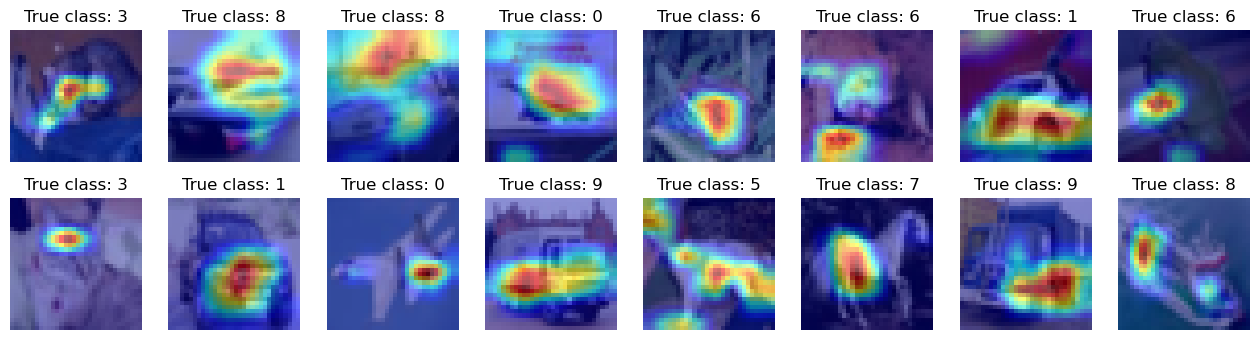

In [32]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Trasformazioni per test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean CIFAR-10
                         (0.2470, 0.2435, 0.2616))  # std CIFAR-10
])


test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

model = CNN(num_classes=10)
model.load_state_dict(torch.load("./models/CNN_final_20250821-181751.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Seleziona l'ultimo layer convoluzionale
target_layer = model.features[-4]  # ultimo Conv2d prima del maxpool finale

# Numero di immagini dal test_loader da visualizzare
num_images = 16

# Prendi un batch dal test_loader
images, labels = next(iter(test_loader))  # immagini e labels
images = images[:num_images].to(DEVICE)
labels = labels[:num_images]

# Inizializza GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

plt.figure(figsize=(16, 4))

# Loop sulle immagini
for i in range(num_images):
    img_tensor = images[i].unsqueeze(0)  # aggiungi dimensione batch

    # Normalizza per visualizzazione: converti da tensor [C,H,W] a [H,W,C] e scala 0-1
    img_for_display = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    img_for_display = (img_for_display - img_for_display.min()) / (img_for_display.max() - img_for_display.min())

    # Calcola Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor)[0, :]

    # Overlay CAM sull'immagine
    cam_image = show_cam_on_image(img_for_display, grayscale_cam, use_rgb=True)

    # Visualizza
    #plt.figure(figsize=(4,4))
    plt.subplot(2, 8, i+1)
    plt.title(f"True class: {labels[i].item()}")
    plt.imshow(cam_image)
    plt.axis('off')
plt.show()

cv2.destroyAllWindows()